#   Differential gene expression analysis

![](./images/Module2/DE_pipeline.jpg)

The next step in the pathway analysis workflow is the differential expression (DE)  analysis. The goal of DE testing is to determine which genes are expressed at different levels between two or more biological conditions. These genes can offer biological insight into the processes affected by the condition(s) of interest. DE analysis means taking the normalised read count data and performing statistical analysis to discover quantitative changes in expression levels between experimental groups. For example, we use statistical testing to decide whether, for a given gene, an observed difference in read counts is significant, that is, whether it is greater than what would be expected just due to natural random variation. This learning module demonstrates a computational workflow for the detection of DE genes from RNA-Seq data.

## Learning Objectives:
1. Assigning samples into groups and set up design matrix.
2. Performing differential expression (DE) analysis using `limma`, `t-test`, `edgeR` and `DEseq` R package.
3. Filtering and exporting the results table.
4. Further visualisation

## Grouping samples and setting up the design matrix.
In this section we will perform differential expression (DF) analysis to analyze the `GSE48350` dataset that we have used in the previous chapter.
Recall from the [**GEO Data processing** ](./Module01-GEO_Data_Processing.ipynb) section,`GSE48350` contains
sequenced data of Human Alzheimer's Disease using microarray sequencing technology collected from 4 brain regions.
Here we will create two groups: *"condition"* and *“control”* from the Entorhinal Cortex region. First, we need to load necessary R libraries to download the dataset.

In [1]:
suppressMessages({if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
  suppressWarnings(BiocManager::install("GEOquery", update = T))
  suppressWarnings(BiocManager::install("limma", update = T))
})

In [2]:
suppressPackageStartupMessages({
  library("GEOquery")
  library("limma")
})

Similar to the [**GEO Data processing** ](./Module01-GEO_Data_Processing.ipynb) section, we can use <a href="https://bioconductor.org/packages/release/bioc/html/GEOquery.html">GEOquery</a> R package to download GEO data and select samples generated from Affymetrix Human Genome U133 Plus 2.0 Array platform.

In [3]:
# Load series and platform data from GEO
gset <- suppressMessages(getGEO("GSE48350", GSEMatrix =TRUE, AnnotGPL=TRUE))
# Check how many platform available
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]
# Get expression data matric
expression_data <- exprs(gset)

We can check for number of samples and genes using this command:

In [4]:
print(paste0("#Genes: ",dim(expression_data)[1]," - #Samples: ",dim(expression_data)[2]))

[1] "#Genes: 54675 - #Samples: 253"


Now we need to select the samples that belong to entorhinal cortex region using following command

In [5]:
# Get samples information
samples <- pData(gset)
# Select sample from Entorhinal Cortex region
idx <- grep("entorhinal", samples$`brain region:ch1`)
gset = gset[ ,idx]
samples = samples[idx,]
# Get expression data for samples collected from entorhinal cortex region
expression_data = expression_data[,idx]
# Print out new number genes and samples
print(paste0("#Genes: ",dim(expression_data)[1]," - #Samples: ",dim(expression_data)[2]))

[1] "#Genes: 54675 - #Samples: 54"


We can see that there are 54 samples that were collected from entorhinal cortex region. Next, we need to perform a $log_2$ transformation.

In [6]:
# Calculate quantile values from the data
qx <- as.numeric(quantile(expression_data, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
# Perform log2 transformation
LogC <- (qx[5] > 100) || (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { expression_data[which(expression_data <= 0)] <- NaN
exprs(gset) <- log2(expression_data)}

In order to perform DE analysis, we need to group patients into two groups: *“condition”* and *“control”*. From the samples source name, patients diagnosed with Alzheimer's Disease are annotated with 'AD'. Therefore, any samples that contain string 'AD' are labelled by 'd' (condition/disease) and the remaining samples are assigned to 'c' (control/normal). The code to group the samples is presented below:

In [7]:
# Select diease samples
disease_idx <- grep("AD", samples$source_name_ch1)
# Create a vector to store label
groups <- rep("X", nrow(samples))
# Annotate a diasease sameples as "d"
groups[disease_idx] <- "d"
# Control samples are labeled as "c"
groups[which(groups!="d")] <- "c"
groups <- factor(groups)

## DE analysis using limma.
Now, we need to specify the model to be fitted using `limma`. Linear modelling in `limma` is carried out using the `lmFit` and `contrasts.fit` functions originally written for application to microarrays. The functions can be used for both microarray and RNA-seq data and fit a separate model to the expression values for each gene. Next, empirical Bayes moderation is carried out using `eBayes` function.  Empirical Bayes moderation borrows information across all the genes to obtain more precise estimates of gene-wise variability. The model’s residual variances are plotted against average expression values in the next figure. It can be seen from this plot that the variance is no longer dependent on the mean expression level.

In [8]:
# Add groups to gset object
gset$group <- groups
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(groups)
fit <- lmFit(gset, design)  # fit linear model
# set up contrasts of interest and recalculate model coefficients
cts <- paste("c", "d", sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)

To see the number of significantly up- and down-regulated genes, we can use the code below to generate the summary table.

In [9]:
dt <- decideTests(fit2,p.value=0.05)
summary(dt)

         c-d
Down     293
NotSig 53893
Up       489

Here, significance is defined using an adjusted p-value cutoff that is set at 5% by default. For the comparison between expression levels in *“condition”* (d) and *“control”* (c), 293 genes are found to be down-regulated and 489 genes are up-regulated. We also can extract a table of the top-ranked genes from a linear model fit using `topTable` function. By default, `topTable` arranges genes from smallest to largest adjusted p-value with associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-value for each gene. The number of top genes displayed can be specified, where `number=Inf` includes all genes. In the following code, we will select top 1,000 genes are differentially expressed.

In [10]:
top_genes <- topTable(fit2, adjust="fdr", sort.by="B", number=1000)

By default, the `topTable` function generates a dataframe that consists of DE genes, statistic and other features. We do not need all the features to perform pathway and enrichment analyses in the later module. Therefore, we will select a subset of `topTable` output by using the following command:

In [11]:
top_genes <- subset(top_genes, select=c("ID","Gene.symbol","adj.P.Val","P.Value","t","B","logFC"))

In order to perform pathway and enrichment analyses, we only focus on the genes that are statistically significant and the probe IDs that have gene symbols. We can select those genes using the following command:

In [12]:
top_genes <- top_genes[which(top_genes$adj.P.Val<0.05),]
top_genes <- top_genes[which(top_genes$Gene.symbol!=""),]
head(top_genes)

,ID,Gene.symbol,adj.P.Val,P.Value,t,B,logFC
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,224687_at,ANKIB1,1.575045e-38,5.761483e-43,-42.51195,71.37488,-5.0270459
234109_x_at,234109_x_at,ONECUT3,3.581024e-28,3.929793e-32,-26.08643,56.26670,-0.5401491
230832_at,230832_at,RTF1,5.202052e-28,6.660149e-32,25.81105,55.88888,1.5886452
236977_at,236977_at,LOC646588,3.302438e-25,5.436112e-29,22.51884,50.90379,1.2085885
211318_s_at,211318_s_at,RAE1,6.039523e-25,1.104622e-28,22.19198,50.35766,2.9567118
219554_at,219554_at,RHCG,2.166963e-24,4.359689e-28,21.56994,49.29043,0.9245753


Now, we can use the following script to save the DE genes list to use in the later modules.


In [13]:
saveRDS(top_genes, file="./data/DE_genes.rds")

## DE analysis using t-test

In [14]:
suppressMessages({
  suppressWarnings(install.packages("matrixTests",quiet= T))
})
# Load matrixTests package
suppressPackageStartupMessages({library("matrixTests")})

package 'matrixTests' successfully unpacked and MD5 sums checked


In [15]:
count <- expression_data
X <- count[,groups=="c"]
Y <- count[,groups=="d"]

In [16]:
res <- row_t_equalvar(X,Y,alternative = "two.sided", mu = 0, conf.level = 0.95)

In [17]:
res <- res[order(res$pvalue),]
res <- res[res$pvalue<0.05,]

## DE analysis using edgeR

In [18]:
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("edgeR", update = F))
})

# Load edgeR package
suppressPackageStartupMessages({library("edgeR")})

In [19]:
count <- expression_data

In [20]:
dge <- DGEList(counts = count, group = factor(gset$group))
keep <- filterByExpr(y = dge)
dge <- dge[keep,keep.lib.sizes=TRUE]
dge <- calcNormFactors(object = dge)
dge <- estimateDisp(y = dge)
et <- exactTest(object = dge)
top_degs = topTags(object = et, n = "Inf")

Using classic mode.



In [21]:
write.csv(et$table, file="./data/edgeR_Results.csv")
saveRDS(et$table, file="./data/edgeR_Results.rds")

In [22]:
summary(decideTests(object = et, lfc = 1))

       d-c
Down     0
NotSig   5
Up       3

In [23]:
## DE analysis using DESeq2

In [24]:
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("DESeq2", update = F))
})
suppressPackageStartupMessages({library("DESeq2")})

In [25]:
coldata <- data.frame(
  sample = colnames(expression_data),
  condition = as.factor(groups),
  row.names = "sample" )

In [26]:
head(coldata)

,condition
,<fct>
GSM300173,c
GSM300177,c
GSM300181,c
GSM300186,c
GSM300189,c
GSM300192,c


In [27]:
range(count)

[1]    0.010 1054.465

In [28]:
dds <- DESeqDataSetFromMatrix(countData = round(count), colData = coldata,
                              design = ~ condition)

converting counts to integer mode



In [29]:
dds <- dds[rowSums(counts(dds)) >= 10,]
dds$condition <- relevel(dds$condition, ref = "c")
dds <- DESeq(dds)
resultsNames(dds)
res <- results(dds)
res <- as.data.frame(res[order(res$padj),])

estimating size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



final dispersion estimates



fitting model and testing



-- replacing outliers and refitting for 85 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



estimating dispersions



fitting model and testing



[1] "Intercept"        "condition_d_vs_c"

In [30]:
summary(results(dds),alpha = 0.05)


out of 50892 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 0.0098%
LFC < 0 (down)     : 1, 0.002%
outliers [1]       : 0, 0%
low counts [2]     : 1, 0.002%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [31]:
write.csv(res, file="./data/DESeq2_Results.csv")
saveRDS(res, file="./data/DESeq2_Results.rds")

## Visualization of of differential expression results.
To summarise results for all genes visually, mean-difference plots, which display log-FCs from the linear model fit against the average log-CPM values can be generated using the `plotMD` function, with the differentially expressed genes highlighted.

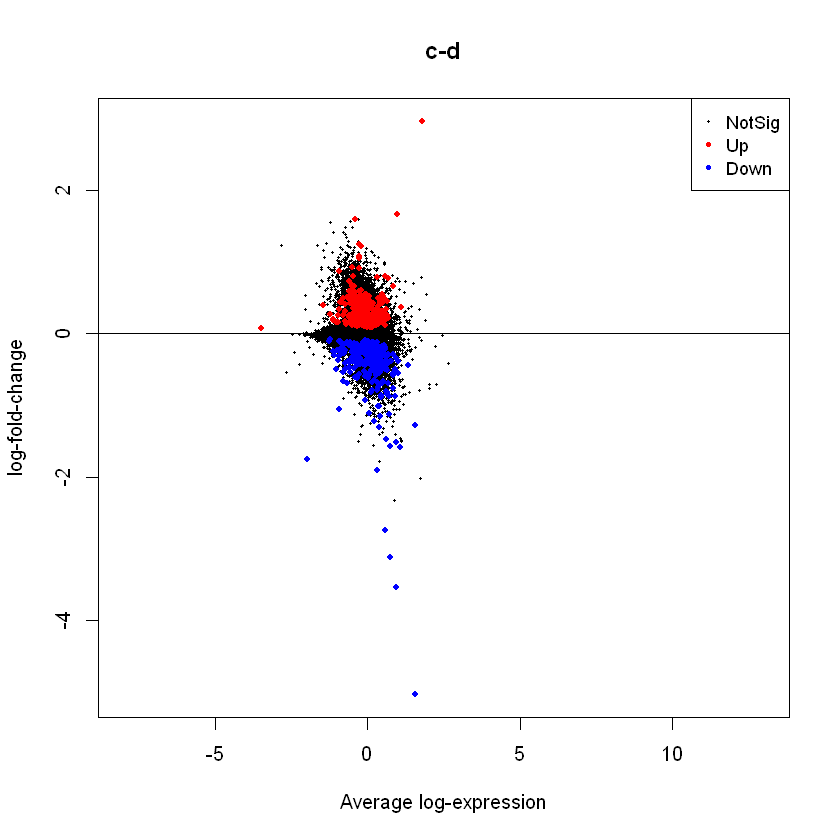

In [32]:
plotMD(fit2, column=1, status=dt[,1], main=colnames(fit2)[1],
       xlim=c(-8,13),pch=20, cex=1)
abline(h=0)

Another way to visualize the number of regulated and unregulated genes is to use Venn diagram. The command to generate the diagram is presented below

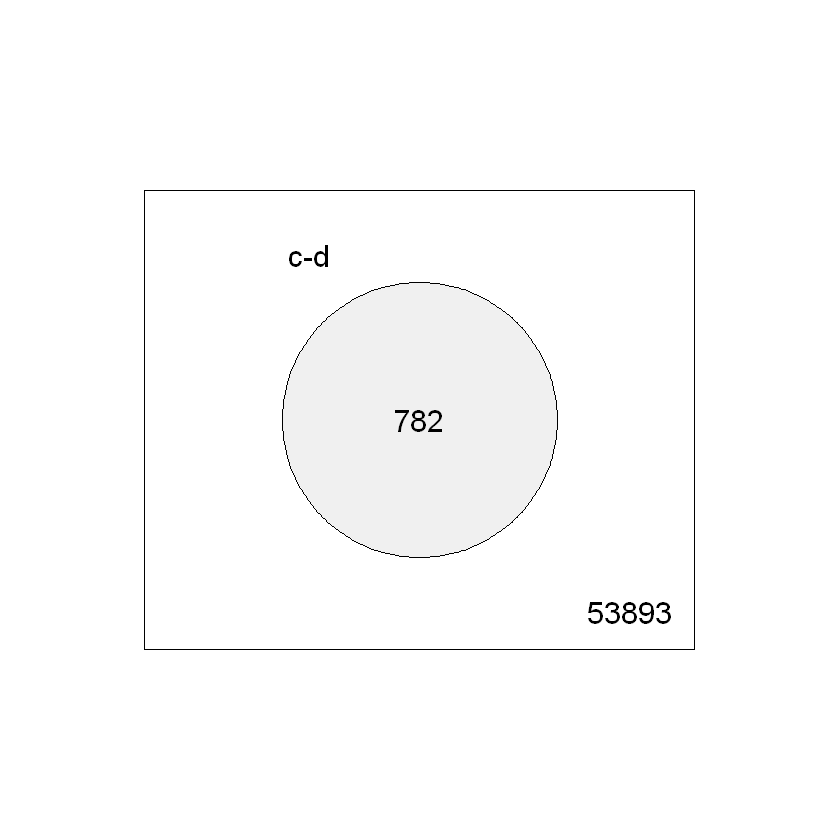

In [33]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)
# Venn diagram of results
vennDiagram(dT, circle.col=palette())

We can visualize the adjusted p-value distribution for all gene using histogram plot as follow

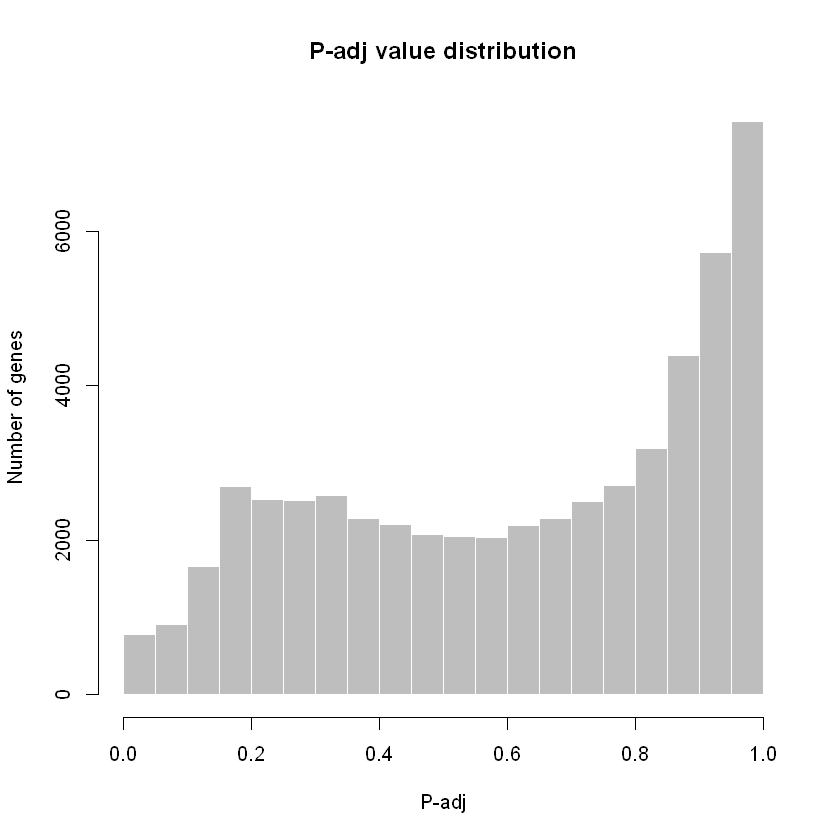

In [34]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "P-adj value distribution")

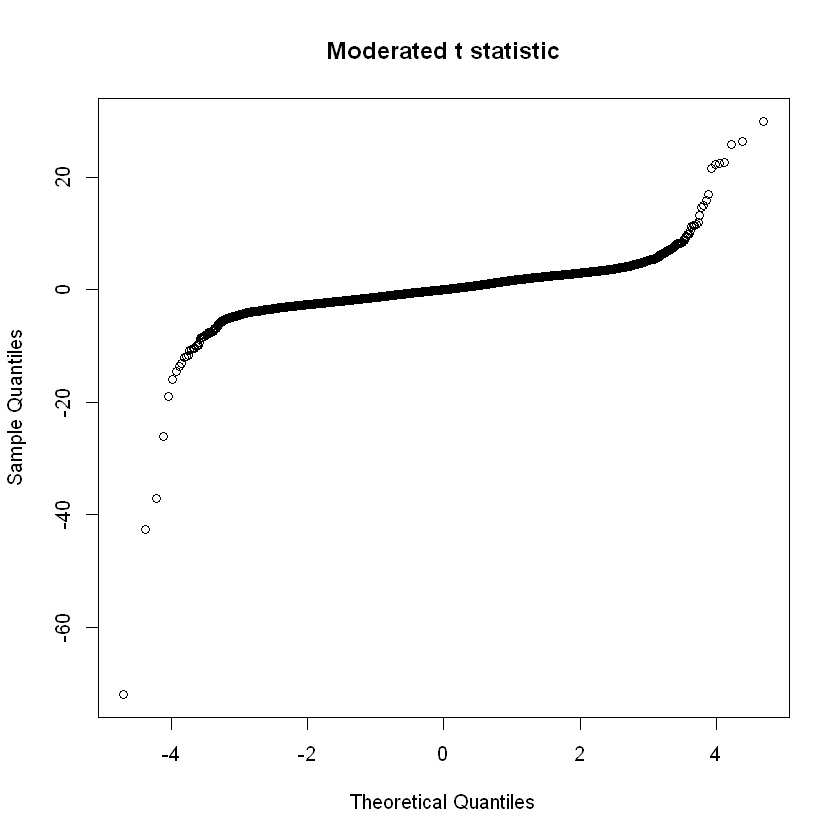

In [35]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

[1] "c-d"

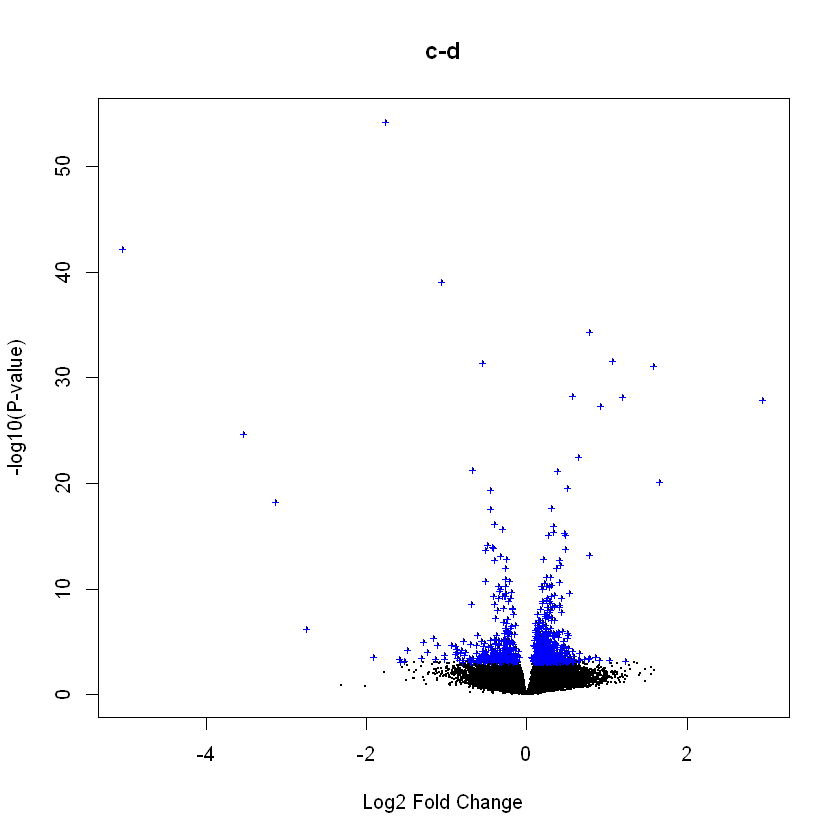

In [36]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))